# Setting up

In [ ]:
!gdown --id 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id 1doKr_6jKH1kwFFCL92LhAHnDwHVmCQVK
!gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
!mkdir ~/.demoji
!mv codes.json ~/.demoji/
!unzip wassa_dataset.zip
!rm wassa_dataset.zip

In [2]:
!pip install -qq demoji
!pip install -qq unidecode
!pip install -qq snowballstemmer

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle
import snowballstemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [4]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

[nltk_data]    |   Package nps_chat is already up-to-date!
[nltk_data]    | Downloading package omw to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package omw is already up-to-date!
[nltk_data]    | Downloading package omw-1.4 to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package opinion_lexicon to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package opinion_lexicon is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package panlex_swadesh is already up-to-date!
[nltk_data]    | Downloading package paradigms to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package paradigms is already up-to-date!
[nltk_data]    | Downloading package pe08 to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package pe08 is already up-

[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package ycoe to
[nltk_data]    |     /Users/badnick/nltk_data...
[nltk_data]    |   Package ycoe is already up-to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection all


True

# Loading the dataset

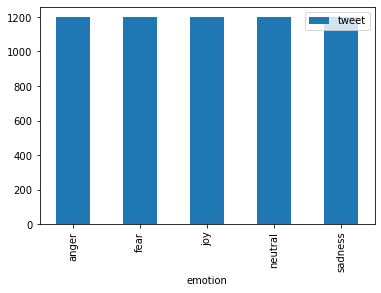

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [5]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")
n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()
print(n_samples)

In [6]:
labels = ['joy', 'anger', 'fear', 'sadness', 'neutral']

# Useful functions

In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 20})
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [8]:
def preprocess_text(text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [9]:
def preprocess_text_list(text_list, stop_words):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i], stop_words)

In [10]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

In [11]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


# Preprocessing

In [12]:
train_texts = df_train["tweet"].tolist()
val_texts = df_val["tweet"].tolist()
test_texts = df_test["tweet"].tolist()


train_labels = df_train["emotion"].tolist()
val_labels = df_val["emotion"].tolist()
test_labels = df_test["emotion"].tolist()

train_labels[:10]

['joy',
 'anger',
 'neutral',
 'neutral',
 'anger',
 'joy',
 'neutral',
 'sadness',
 'sadness',
 'neutral']

## English

In [13]:
stop_words = stopwords.words("english")  # loads english stopwords

preprocess_text_list(train_texts, stop_words)
preprocess_text_list(val_texts,  stop_words)
preprocess_text_list(test_texts, stop_words)

train_texts[:10]

['kinda wish watch mischiev kiss play kiss ',
 'forget mention bought dreamboy ticket ',
 'yep  jimmi buffett ftw     jimmi need tweet word wisdom everi morn ',
 'blue sky   s still grey hazi window ',
 'move clip youtub tonight vigil held tulsa metropolitan baptist church  terencecruth  justic  sad ',
 'make success  happi forev ',
 'morn hon  breakfast  cant decid ',
 'standard candic start show pout  startasyoumeantogoon  gbbo ',
 '   would frown bit  fold arm  whi everi time m need assist someon expect lil   ',
 'someon make cofffeeeeee  ']

# Encoding

In [14]:
 # Vectorizing texts
 vectorizer = TfidfVectorizer()
 vectorizer.fit(train_texts)

TfidfVectorizer()

In [15]:
vectorized_train_texts = vectorizer.transform(train_texts)
vectorized_val_texts = vectorizer.transform(val_texts)
vectorized_test_texts = vectorizer.transform(test_texts)

In [16]:
# label encoding
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

# SVM

## Defining the model

In [17]:
svm_model = svm.SVC(probability=True)
svm_model.fit(vectorized_train_texts, encoded_train_labels)

SVC(probability=True)

## Validation

In [18]:
y_pred = svm_model.predict_log_proba(vectorized_val_texts)
y_pred

array([[-5.88347877e+00, -3.17032720e+00, -2.39790863e-01,
        -4.65663840e+00, -1.83926416e+00],
       [-7.03154587e+00, -2.66704818e-02, -6.56134545e+00,
        -3.80682608e+00, -6.31895168e+00],
       [-1.77472971e+01, -1.62768480e-04, -1.47040695e+01,
        -8.82276277e+00, -1.11085511e+01],
       ...,
       [-6.40867285e-01, -2.53805997e+00, -4.12139833e+00,
        -1.63060027e+00, -1.70313710e+00],
       [-5.13583663e+00, -5.90313369e+00, -9.05683515e-02,
        -2.84422392e+00, -3.92229063e+00],
       [-6.35815128e+00, -4.62526507e+00, -5.02342603e+00,
        -2.13366933e-01, -1.74855754e+00]])

In [19]:
acc = accuracy_score(encoded_val_labels, np.argmax(y_pred, axis=1))
precision = precision_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
recall = recall_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
f1 = f1_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

Model has acc = 0.8706666666666667
, precision = 0.8706666666666667
, recall = 0.8706666666666667
, f1_score = 0.8706666666666667



## Testing

In [20]:
y_pred = svm_model.predict(vectorized_test_texts)

In [21]:
compute_metrics(encoded_test_labels, y_pred)


Model has acc = 0.8386666666666667
, precision = 0.8444967569787878
, recall = 0.8386666666666667
, f1_score = 0.8404916569671421



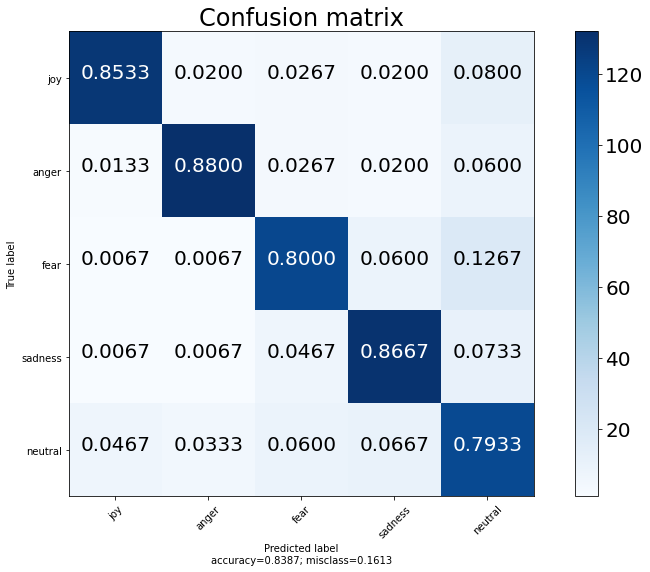

In [22]:
y_pred = label_encoder.inverse_transform(y_pred)
cm = confusion_matrix(test_labels, y_pred, labels=labels)
plot_confusion_matrix(cm, labels)

In [23]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

       anger       0.93      0.88      0.90       150
        fear       0.83      0.80      0.82       150
         joy       0.92      0.85      0.89       150
     neutral       0.70      0.79      0.74       150
     sadness       0.84      0.87      0.85       150

    accuracy                           0.84       750
   macro avg       0.84      0.84      0.84       750
weighted avg       0.84      0.84      0.84       750



In [24]:
with open('svm_model.pkl', 'wb') as files:
    pickle.dump(svm_model, files)

In [25]:
with open('tfid.pkl', 'wb') as files:
    pickle.dump(vectorizer, files)

In [26]:
with open('encoder.pkl', 'wb') as files:
    pickle.dump(label_encoder, files)